In [1]:
%matplotlib inline
from re import DEBUG
from turtle import color
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from warnings import simplefilter
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import WindowsPath
import time
from collections import defaultdict
import re


In [2]:
DEBUGGING: bool = False
NUM_EVENT_PER_POS = 100
MAP_SET_PADS_TO_TRIANGLE = defaultdict(
    int,
    {
        frozenset([6, 5, 4]): 1,
        frozenset([4, 5, 3]): 2,
        frozenset([4, 3, 2]): 3,
        frozenset([3, 2, 1]): 4,
        frozenset([6, 8, 5]): 5,
        frozenset([5, 3, 13]): 6,
        frozenset([3, 13, 1]): 7,
        frozenset([8, 5, 10]): 8,
        frozenset([5, 10, 13]): 9,
        frozenset([13, 1, 14]): 10,
        frozenset([8, 9, 10]): 11,
        frozenset([10, 11, 13]): 12,
        frozenset([11, 13, 14]): 13,
        frozenset([9, 10, 11]): 14,
    },
)
max_num_triangle: int = 14
COL_PADS = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14])
UNIT_OF_MEASURE_COL = {
    "pmax": "mV",
    "negpmax": "mV",
    "tmax": "ns",
    "area": "mV $\\cdot$ ns",
    "rms": "mV",
}


In [3]:

dev_df = pd.read_csv(
    "development_sampled.csv", header=0, index_col=False
)
dev_df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.6,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,4.419153,-4.016150,2.208147,200.6,1.354330,4.569540,-3.599734,5.106657,...,604.804281,-45.927228,572.654111,70.853335,0.369911,633.337711,-51.585175,595.176544,71.023276,0.340699
2,200.0,220.0,4.917316,-5.275555,3.161569,96.0,0.667449,5.091223,-5.380579,4.139687,...,592.802722,-43.782382,594.410026,72.334749,0.423974,604.958497,-43.260779,582.041404,72.327402,0.339521
3,200.0,220.0,3.685220,-3.443735,1.693155,14.2,0.963643,6.157217,-5.241187,16.244604,...,655.475259,-40.479129,590.941372,72.263393,0.391574,600.667248,-51.152997,574.662360,72.442222,0.459366
4,200.0,225.0,5.787140,-4.168427,4.506842,50.0,2.164724,4.861826,-4.556509,4.533303,...,601.845795,-46.553644,592.232553,71.815485,0.445192,589.658359,-51.258679,581.631943,71.800134,0.358580


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[14]', ylabel='Proportion'>

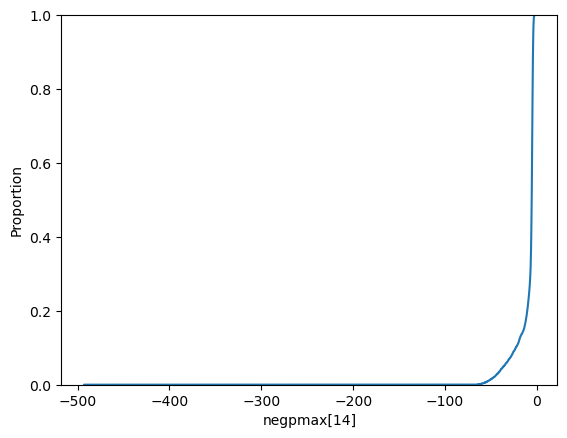

In [4]:
name_cols: list[str] = []
prefix = "pmax"
for i in range(18):
    name_cols.append(f"{prefix}[{i}]")

# dfm = dev_df.melt(
#     id_vars=["x", "y"],
#     var_name=f"{prefix}",
#     value_name="values",
#     value_vars=name_cols,
# )
# sns.ecdfplot(dfm, y="prefix", x="values", color=sns.color_palette()[0])

sns.ecdfplot(dev_df, x="negpmax[14]", color=sns.color_palette()[0])



C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


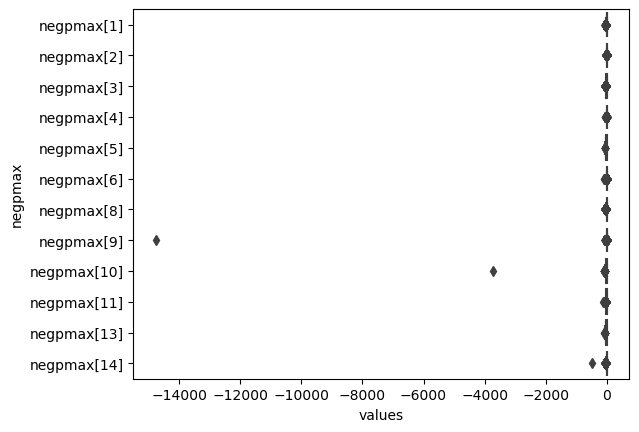

In [5]:
print()
prefix = "negpmax"
name_cols: list[str] = []
for i in [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]:
    name_cols.append(f"{prefix}[{i}]")

dfm = dev_df.melt(
    id_vars=["x", "y"],
    var_name=f"{prefix}",
    value_name="values",
    value_vars=name_cols,
)
plot = sns.boxplot(dfm, y=f"{prefix}", x="values", color=sns.color_palette()[0])
# plt.gca().set(xlim=(-100, 0))

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[8]', ylabel='Count'>

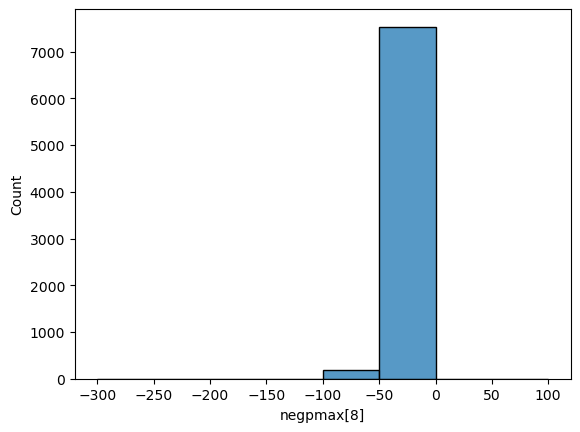

In [6]:
sns.histplot(dev_df, x="negpmax[8]", bins = [-300, -200, -150, -100, -50, 0, 100])

0.0


<Axes: >

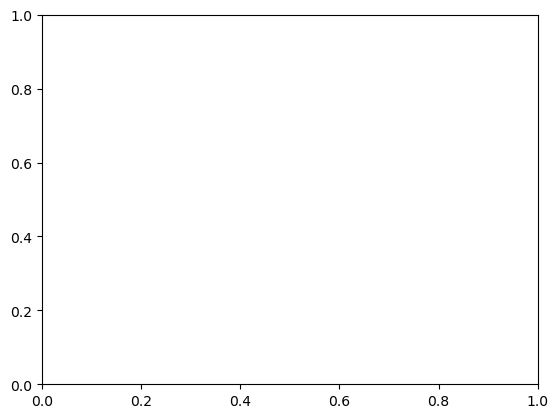

In [7]:

mask = (dev_df["negpmax[8]"]<-100) |  (dev_df["negpmax[8]"]>100)
print(mask.sum()/dev_df.shape[0]*100)
# sns.histplot(dev_df[mask], x="negpmax[8]", bins = [-90000, -300, -200, -150, -100])
sns.ecdfplot(dev_df[mask], x="negpmax[8]", color=sns.color_palette()[1])

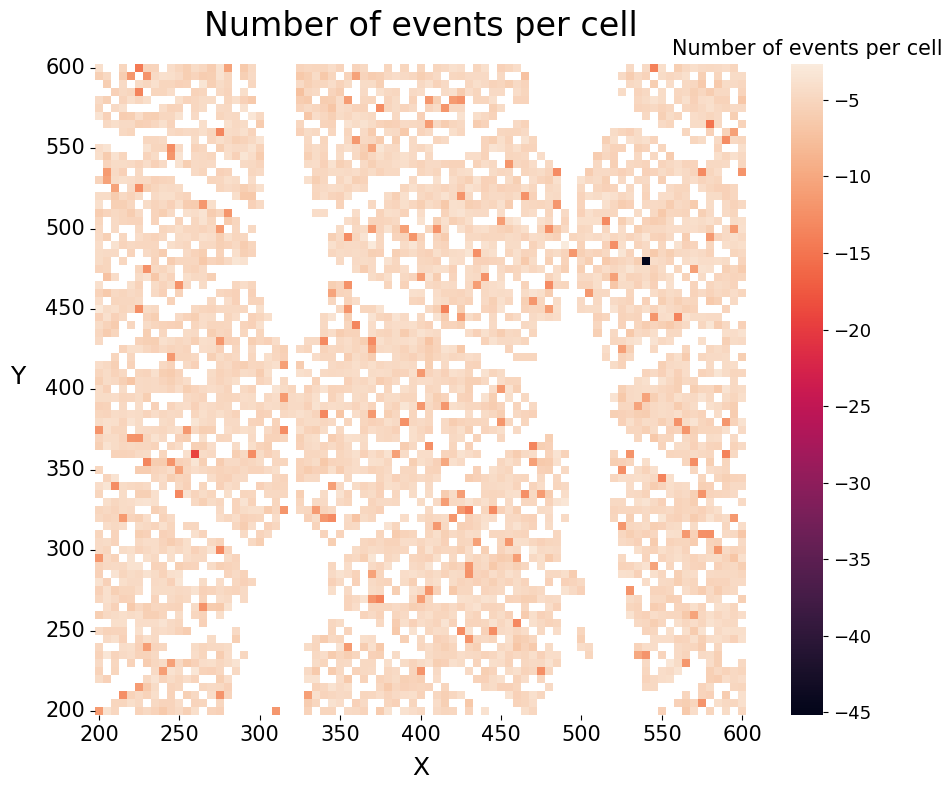

In [8]:
col = 15
name_col = f"negpmax[{col}]"
df_plot = dev_df[["x", "y", name_col]]
mask = (df_plot[name_col]>=-300) & (df_plot[name_col]<=0)
df_plot = df_plot.loc[mask, :]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)



def personalize_heatmap(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    title_colorbar: str,
    xlabel: str,
    ylabel: str,
) -> None:
    fig.set_size_inches(10, 8)

    color_bar = ax.collections[0].colorbar
    color_bar.ax.set_title(title_colorbar, fontsize=15)
    color_bar.ax.tick_params(axis="both", which="major", labelsize=13)
    color_bar.ax.tick_params(axis="both", which="minor", labelsize=13)
    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0)
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=20.0)
    col_labels = [int(col) for col in data_heatmap.columns]
    row_labels = [int(col) for col in data_heatmap.index]
    step = 10
    ax.set_xticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=col_labels[::step],
        fontsize=15,
    )
    ax.set_yticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=row_labels[::step],
        fontsize=15,
    )
    ax.tick_params(axis="x", labelrotation=0)

    plt.tight_layout()


personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Number of events per cell",
    title_colorbar="Number of events per cell",
    xlabel="X",
    ylabel="Y",
)



In [9]:

def feature_extraction(dev_df: pd.DataFrame) -> None:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax
    sorted_index = (-1 * (dev_df[col_pads_pmax].values)).argsort(axis=1)
    # only the first 3 are relevant
    sorted_index = sorted_index[:, :3]
    sorted_index_pd = pd.DataFrame(sorted_index)
    

    def combine_indexes(row: pd.Series):
        global max_num_triangle
        key = frozenset(COL_PADS[row.values])
        if key not in MAP_SET_PADS_TO_TRIANGLE:
            MAP_SET_PADS_TO_TRIANGLE[key] = max_num_triangle + 1
            max_num_triangle = max_num_triangle + 1

        return MAP_SET_PADS_TO_TRIANGLE[key]

    dev_df["triangle"] = sorted_index_pd.apply(combine_indexes, axis=1)
    if DEBUGGING:
        print((dev_df["triangle"] == pd.NA).sum())
        print(dev_df["triangle"])
        print(dev_df[col_pads_pmax].head())
        print(dev_df.tail(20))
        print(dev_df.shape)
        print(sorted_index.shape)
        print(dev_df["triangle"].unique())
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df, x="x", y="y", hue="triangle", palette="Set1", alpha=0.1, ax=ax
    )
    plt.show()
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean(),
        x="x",
        y="y",
        hue="triangle",
        palette="Set1",
        ax=ax,
    )
    plt.show()
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )
    print("Percentage not starting triangles:")
    print((dev_df["triangle"]>14).sum() / dev_df["triangle"].size *100)
    print(sorted_index)
    
    sorted_values = -1*(np.sort(-1 * (dev_df[col_pads_pmax].values),axis=1))
    sorted_values = sorted_values[:, :3]
    print(np.mean(sorted_values, axis = 1))
    print(sorted_values)
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]>14], kde=True, stat="density", color =  sns.color_palette()[0])
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]<=14], kde=True, stat="density", color =  sns.color_palette()[0])
    plt.show()

    
    def get_x_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    def get_y_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    dev_df["x_triag"] = dev_df.apply(get_x_triangle, axis=1)
    dev_df["y_triag"] = dev_df.apply(get_y_triangle, axis=1)
    print(dev_df.head())
    print(sorted_index)


In [16]:
def feature_extraction_2(dev_df: pd.DataFrame) -> None:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax
    

    def define_triangle(row: pd.Series):
        max_val = 0
        key_max = frozenset([6, 5, 4])
        for key in MAP_SET_PADS_TO_TRIANGLE:
            cols_to_select = [f"pmax[{pas}]" for pas in key]
            val = row[cols_to_select].mean()
            if val > max_val:
                max_val = val
                key_max = key
        
        return MAP_SET_PADS_TO_TRIANGLE[key_max]

    dev_df["triangle"] = dev_df[cols].apply(define_triangle, axis=1)
    if True:
        print((dev_df["triangle"] == pd.NA).sum())
        print(dev_df["triangle"])
        print(dev_df[col_pads_pmax].head())
        print(dev_df.tail(20))
        print(dev_df.shape)
        print(dev_df["triangle"].unique())
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df, x="x", y="y", hue="triangle", palette="Set1", alpha=0.1, ax=ax
    )
    plt.show()
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean(),
        x="x",
        y="y",
        hue="triangle",
        palette="Set1",
        ax=ax,
    )
    plt.show()
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )
    print("Percentage not starting triangles:")
    print((dev_df["triangle"]>14).sum() / dev_df["triangle"].size *100)
    
    sorted_values = -1*(np.sort(-1 * (dev_df[col_pads_pmax].values),axis=1))
    sorted_values = sorted_values[:, :3]
    print(np.mean(sorted_values, axis = 1))
    print(sorted_values)
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]>14], kde=True, stat="density", color =  sns.color_palette()[0])
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]<=14], kde=True, stat="density", color =  sns.color_palette()[0])
    plt.show()

    
    def get_x_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    def get_y_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    dev_df["x_triag"] = dev_df.apply(get_x_triangle, axis=1)
    dev_df["y_triag"] = dev_df.apply(get_y_triangle, axis=1)
    print(dev_df.head())


0
0       11
1       11
2       11
3       11
4       11
        ..
7705     4
7706     4
7707     4
7708     4
7709     4
Name: triangle, Length: 7710, dtype: int64
    pmax[1]   pmax[2]   pmax[3]   pmax[4]    pmax[5]   pmax[6]    pmax[8]  \
0  5.409161  6.084506  3.811328  4.893027   9.322305  3.077338  26.581253   
1  4.569540  5.464920  5.149203  3.507779   9.722018  6.416961  27.208676   
2  5.091223  3.191306  5.746016  3.673426   8.053278  5.500221  32.493158   
3  6.157217  5.211008  4.412192  5.186435   5.119852  5.265067  33.073047   
4  4.861826  4.548071  4.900665  4.090005  11.364798  8.232370  35.649860   

      pmax[9]   pmax[10]   pmax[11]  pmax[13]  pmax[14]  
0   99.361264  42.068393  12.438458  7.454877  6.611877  
1  111.329825  47.142776  11.203677  6.069727  5.672940  
2   84.952716  44.967712   9.466507  5.817816  4.891064  
3   85.247296  41.377689  12.444229  8.297433  6.178126  
4   82.808719  42.570795  10.871628  7.053839  5.174684  
          x      y    p

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

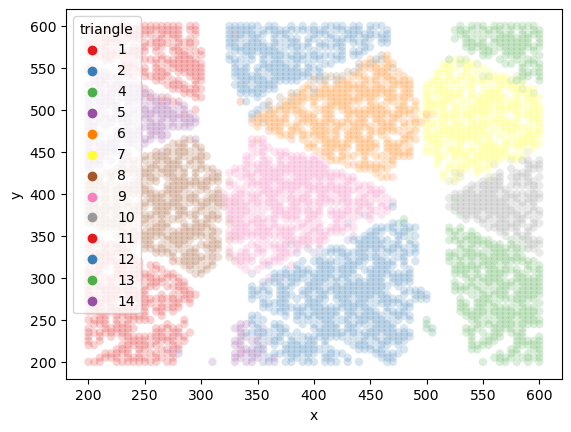

C:\Users\cucch\AppData\Local\Temp\ipykernel_16848\174978419.py:35: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

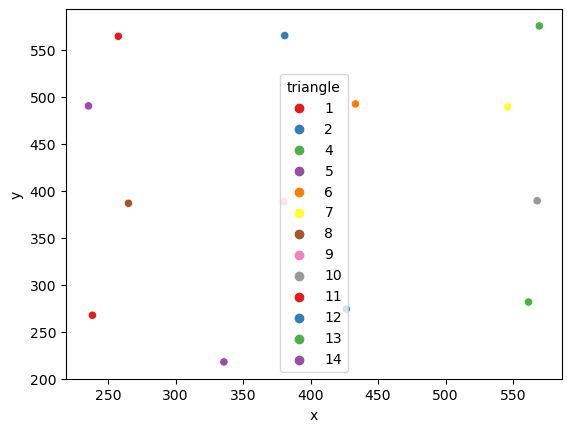

C:\Users\cucch\AppData\Local\Temp\ipykernel_16848\174978419.py:49: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Percentage not starting triangles:
0.0
[56.00363668 61.89375916 54.13786214 ... 57.2458374  54.59788513
 55.60754395]
[[ 99.36126404  42.06839294  26.58125305]
 [111.32982483  47.14277649  27.20867615]
 [ 84.95271606  44.9677124   32.49315796]
 ...
 [ 65.05068359  54.27272034  52.41410828]
 [ 59.76857605  53.3631012   50.66197815]
 [ 65.75853882  54.92953186  46.13456116]]


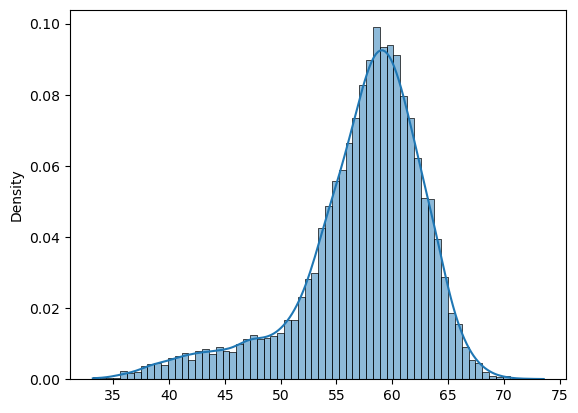

       x      y   pmax[0]  negpmax[0]   area[0]  tmax[0]    rms[0]   pmax[1]  \
0  200.0  200.0  4.066907  -17.690173  2.847932      0.6  2.007042  5.409161   
1  200.0  200.0  4.419153   -4.016150  2.208147    200.6  1.354330  4.569540   
2  200.0  220.0  4.917316   -5.275555  3.161569     96.0  0.667449  5.091223   
3  200.0  220.0  3.685220   -3.443735  1.693155     14.2  0.963643  6.157217   
4  200.0  225.0  5.787140   -4.168427  4.506842     50.0  2.164724  4.861826   

   negpmax[1]    area[1]  ...   tmax[16]   rms[16]    pmax[17]  negpmax[17]  \
0  -17.721210   4.538778  ...  72.373094  0.374498  614.916861   -39.848523   
1   -3.599734   5.106657  ...  70.853335  0.369911  633.337711   -51.585175   
2   -5.380579   4.139687  ...  72.334749  0.423974  604.958497   -43.260779   
3   -5.241187  16.244604  ...  72.263393  0.391574  600.667248   -51.152997   
4   -4.556509   4.533303  ...  71.815485  0.445192  589.658359   -51.258679   

     area[17]   tmax[17]   rms[17]  triangle

In [17]:
feature_extraction_2(dev_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df.drop(["x", "y"], axis=1), dev_df[["x", "y"]], train_size=0.8, shuffle=True
)

regr = RandomForestRegressor(random_state=42, max_features="sqrt")

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

In [ ]:
def personalize_barplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    plt.tight_layout()




def analyse_feature_importante(
    forest: RandomForestRegressor, features_names: list[str]
):
    # TODO: Check the function
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    
    feature_import_df = pd.DataFrame(
        {
            "feature": features_names,
            "importance": importances,
        }
    )
    feature_import_df = feature_import_df.sort_values("importance", ascending=False)
    
    # groupying by type of feature
    feature_cat_import_df = pd.DataFrame(
        {
            "feature": [re.sub(r"\[\d+\]", "", feat) for feat in features_names],
            "importance": importances,
        }
    )
    feature_cat_import_df = feature_cat_import_df.groupby("feature", as_index=False).sum().sort_values("importance", ascending = False)
    print(feature_cat_import_df)
    feature_import_df["std"] = std
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    sns.barplot(feature_cat_import_df, y="feature", x="importance", color=sns.color_palette()[0])
    personalize_barplot(
        ax,
        fig,
        feature_cat_import_df,
        "Feature importance by category",
        "Importance",
        "Feature category",
    )
    plt.show()    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    sns.barplot(feature_import_df, y="feature", x="importance", color=sns.color_palette()[0])
    personalize_barplot(
        ax,
        fig,
        feature_import_df,
        "Feature importance",
        "Importance",
        "Feature",
        12,
        18
    )
    plt.show()    
    plt.clf()
    
    

analyse_feature_importante(
    regr, list(dev_df.drop(["x", "y"], axis=1).columns)
)
dev_df.head()

In [ ]:
def personalize_histplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    ax.lines[0].set_color(sns.color_palette()[1])
    plt.tight_layout()



plt.clf()
fig, ax = plt.subplots(1, 1)
plot = sns.histplot(dev_df, x="pmax[1]", kde=True, stat="density", color =  sns.color_palette()[0])
personalize_histplot(
    ax,
    fig,
    dev_df,
    "Distribution pmax[1]",
    f"pmax[1] [{UNIT_OF_MEASURE_COL['pmax']}]",
    "Density",
)
plt.show() 

In [ ]:
def personalize_boxplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    plt.tight_layout()



name_cols = [f"pmax[{i}]" for i in range(18)]
dfm = dev_df.melt(
    id_vars=["x", "y"],
    var_name=f"pmax",
    value_name="values",
    value_vars=name_cols,
)
plt.clf()
fig, ax = plt.subplots(1, 1)
sns.boxplot(dfm, y=f"pmax", x="values", color=sns.color_palette()[0])
personalize_boxplot(
    ax,
    fig,
    dev_df,
    "Pmax distributions",
    "Distribution",
    "Feature",
    13, 9
)
plt.show()

In [ ]:
 sns.color_palette()[1]